In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import f1_score
from scipy import stats
import statsmodels.api as sm
import glob

In [5]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [6]:
# Normal dataset
#df = pd.read_csv('CSVFiles/smallDomainDataBertweetEmbedded.csv')
#df = pd.read_csv('CSVFiles/small10000DomainDataBertweetEmbedded.csv')
df = pd.read_csv('CSVFiles/small50000DomainDataBertweetEmbedded.csv')
df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

In [7]:
# Updating values for training_data
training_data = df[df['split'] == 'train']

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']

In [8]:
print('Toxic samples training data: ', sum(training_data['toxicity']))
print('None-toxic samples training data: ', len(training_data['toxicity'])-sum(training_data['toxicity']))

print("\n")
print('Toxic samples validation data: ', sum(validation_data['toxicity']))
print('None-toxic samples validation data: ', len(validation_data['toxicity'])-sum(validation_data['toxicity']))

print("\n")
print('Toxic samples test data: ', sum(test_data['toxicity']))
print('None-toxic samples test data: ', len(test_data['toxicity'])-sum(test_data['toxicity']))

print("\n")

for col in training_data.columns[3:]:
    print(col + ": " + str(np.sum(training_data[col])))

Toxic samples training data:  22010.0
None-toxic samples training data:  22010.0


Toxic samples validation data:  1510.0
None-toxic samples validation data:  1510.0


Toxic samples test data:  1510.0
None-toxic samples test data:  1510.0


male: 4567.0
female: 5272.0
LGBTQ: 1652.0
christian: 2300.0
muslim: 2332.0
other_religion: 20.0
black: 2475.0
white: 3818.0


In [9]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)
    
def CreatePlot(trainArr, valArr, path):
    plt.figure()
    plt.scatter(np.arange(0,len(trainArr)), trainArr, color='r', label='Training loss')
    plt.scatter(np.arange(0,len(valArr)), valArr, color='g', label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    print(path)
    plt.savefig(path, bbox_inches='tight')
    plt.show()

In [10]:
### Set parameters for the model
#torch.manual_seed(1) # set fixed random seed for reproducibility
cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [11]:
# Creating data loaders
X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

X_val = np.array(validation_data['comment_text'].values.tolist())
Y_val = np.array(validation_data['toxicity'].values.tolist())

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(768, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [10]:
def Train(model, train_loader, valid_loader, loss_function, optimizer, learning_rate, early_stopping=50, epochs=1000):
    
    # Setting up model parameters
    model = model.to(device)
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    if optimizer == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    if optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    loss_function = loss_function

    # Initialising early stopping criterias
    early_stopping = early_stopping
    notImproved = 0
    
    bestLoss = None
    bestModel = None

    trainArr = []
    valArr = []

    bestf1 = 0
    bestEpoch = 0

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
        
            # get the input
            inputs, labels = data
    
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
        
            optimizer.zero_grad()
        
            outputs = model(inputs)
            outputs = outputs.squeeze(1)
        
            loss = loss_function(outputs, labels)
        
            loss.backward()
        
            optimizer.step()
        
            train_loss += loss.item()
    
        train_loss /= len(train_loader.dataset)    
        trainArr.append(train_loss)
    
        valid_loss = 0
        labs = []
        preds = []
        
        model.eval()
        with torch.no_grad():        
            for batch_idx, data in enumerate(valid_loader):
                # get the input
                inputs, labels = data           
            
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                
                outputs = model(inputs).squeeze()
                
                labs.extend(labels)
                preds.extend(torch.round(outputs))
            
                valid_loss += loss_function(outputs, labels).item()
        
        valid_loss /= len(valid_loader.dataset)
        valArr.append(valid_loss)
        
        if bestLoss == None:
            bestLoss = valid_loss
    
        if valid_loss <= bestLoss:
            bestModel = torch.save(model, 'currentModel.pth')
            bestLoss = valid_loss
            notImproved = 0
            bestEpoch = epoch
        else:
            notImproved +=1
        
        if notImproved >= early_stopping:
            break

    model = torch.load('currentModel.pth')
    return model, valArr, trainArr, epoch

In [50]:
def DemoAndF1AndAcc(class_model, pca_model, df):
    f1_scores = []
    accuracies = []
    demographics = []
    
    for col in df.columns[3:]:
        tempdf = df[(df[col] == 1)]
        
        tempX = np.array(tempdf['comment_text'].values.tolist())
        tempY = np.array(tempdf['toxicity'].values.tolist())
        
        transformedXTest = pca_model.transform(tempX)
        prep_testloader = []
        for i in range(len(tempX)):
            prep_testloader.append([transformedXTest[i], Y_train[i]])
        
        test_loader = torch.utils.data.DataLoader(prep_testloader, batch_size=32, shuffle=False)
        
        labs = []
        preds = []
        class_model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loader):
                inputs, labels = data
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                outputs = class_model(inputs).squeeze()
                labs.extend(labels)
                preds.extend(torch.round(outputs))
                
        labs = torch.Tensor(labs).detach().numpy()
        preds = torch.Tensor(preds).detach().numpy()
        
        f1_scores.append(f1_score(labs, preds, zero_division=1))
        accuracies.append(CheckAccuracy(labs, preds))
        demographics.append(col)
            
    return np.array(demographics), np.array(f1_scores), np.array(accuracies)

def pRule(class_model, pca_model, df):
    pRules = []
    
    for col in df.columns[3:]:
        
        tempdfz1 = df[(df[col] == 1)]
        tempdfz0 = df[(df[col] == 0)]
        
        tempXz1 = np.array(tempdfz1['comment_text'].values.tolist())
        tempYz1 = np.array(tempdfz1['toxicity'].values.tolist())
        
        tempXz0 = np.array(tempdfz0['comment_text'].values.tolist())
        tempYz0 = np.array(tempdfz0['toxicity'].values.tolist())
        
        # For z=1
        transformedtempXz1 = pca_model.transform(tempXz1)
        prep_testloaderz1 = []
        for i in range(len(transformedtempXz1)):
            prep_testloaderz1.append([transformedtempXz1[i], tempYz1[i]])
            transformedtempXz1 = pca_model.transform(tempXz1)
        test_loaderz1 = torch.utils.data.DataLoader(prep_testloaderz1, batch_size=32, shuffle=False)
        
        labsz1 = []
        predsz1 = []
        class_model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loaderz1):
                inputs, labels = data
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                outputs = class_model(inputs).squeeze()
                labsz1.extend(labels)
                predsz1.extend(torch.round(outputs))
        
        # For z=0
        transformedtempXz0 = pca_model.transform(tempXz0)
        prep_testloaderz0 = []
        for i in range(len(transformedtempXz0)):
            prep_testloaderz0.append([transformedtempXz0[i], tempYz0[i]])
        test_loaderz0 = torch.utils.data.DataLoader(prep_testloaderz0, batch_size=32, shuffle=False)
        
        labsz0 = []
        predsz0 = []
        class_model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loaderz0):
                inputs, labels = data
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                outputs = class_model(inputs).squeeze()
                labsz0.extend(labels)
                predsz0.extend(torch.round(outputs))
        
        predictionsz1 = torch.Tensor(predsz1).detach().numpy()
        predictionsz0 = torch.Tensor(predsz0).detach().numpy()
        
        with np.errstate(divide='ignore'):
            
            z1Ut1 = np.sum(predictionsz1)/len(df)
            pz1 = len(predictionsz1)/len(df)
            
            z0Ut1 = np.sum(predictionsz0)/len(df)
            pz0 = len(predictionsz0)/len(df)

            pscore0 = (z1Ut1/pz1) / (z0Ut1/pz0)
            pscore1 = (z0Ut1/pz0) / (z1Ut1/pz1)
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules

def pRuleOwn(class_model, pca_model, df):
    pRules = []
    
    for col in df.columns[3:]:
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        tempXz1 = np.array(tempdfz1['comment_text'].values.tolist())
        tempYz1 = np.array(tempdfz1['toxicity'].values.tolist())
        
        tempXz0 = np.array(tempdfz0['comment_text'].values.tolist())
        tempYz0 = np.array(tempdfz0['toxicity'].values.tolist())
        
        # For z=1
        transformedtempXz1 = pca_model.transform(tempXz1)
        prep_testloaderz1 = []
        for i in range(len(transformedtempXz1)):
            prep_testloaderz1.append([transformedtempXz1[i], tempYz1[i]])
            transformedtempXz1 = pca_model.transform(tempXz1)
        test_loaderz1 = torch.utils.data.DataLoader(prep_testloaderz1, batch_size=32, shuffle=False)
        
        labsz1 = []
        predsz1 = []
        class_model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loaderz1):
                inputs, labels = data
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                outputs = class_model(inputs).squeeze()
                labsz1.extend(labels)
                predsz1.extend(torch.round(outputs))
        
        # For z=0
        transformedtempXz0 = pca_model.transform(tempXz0)
        prep_testloaderz0 = []
        for i in range(len(transformedtempXz0)):
            prep_testloaderz0.append([transformedtempXz0[i], tempYz0[i]])
        test_loaderz0 = torch.utils.data.DataLoader(prep_testloaderz0, batch_size=32, shuffle=False)
        
        labsz0 = []
        predsz0 = []
        class_model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loaderz0):
                inputs, labels = data
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                outputs = class_model(inputs).squeeze()
                labsz0.extend(labels)
                predsz0.extend(torch.round(outputs))
        
        predictionsz1 = torch.Tensor(predsz1).numpy()
        predictionsz0 = torch.Tensor(predsz0).numpy()
        
        with np.errstate(divide='ignore'):
            
            pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
            pscore1 = (np.sum(predictionsz0)/np.sum(tempYz0))/(np.sum(predictionsz1)/np.sum(tempYz1))
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules

def MinMaxFairness(scores):
    return np.max(scores)-np.min(scores)

def VarianceFairness(scores):
    return np.var(scores)

In [51]:
epsilons = []
pathArrPCA = []

for filePath in glob.glob('PCAmodels1000/*'):
    pathArrPCA.append(filePath)
    epsilons.append(filePath[14:-4].replace(',', '.'))

epsilons = np.array(epsilons, dtype=float)
pathArrPCA = np.array(pathArrPCA)

# sort by epsilons
sortedIndexes = np.argsort(epsilons)
epsilons = epsilons[sortedIndexes]
pathArrPCA = pathArrPCA[sortedIndexes]


pathArrFC = []
epsilons = []
for filePath in glob.glob('PrivateModels50000/Models/*'):
    epsilons.append(filePath[33:-4].replace(',', '.'))
    pathArrFC.append(filePath)
    
epsilons = np.array(epsilons, dtype=float)
pathArrFC = np.array(pathArrFC)

# sort by epsilons
sortedIndexes = np.argsort(epsilons)
epsilons = epsilons[sortedIndexes]
pathArrFC = pathArrFC[sortedIndexes]

varF1 = []
varAcc = []
minMaxF1 = []
minMaxAcc = []
pRuleOwnMeanArr = []
pRuleOwnMinArr = []
pRuleMeanArr = []
pRuleMinArr = []
accuracy = []

for i in range(len(pathArrFC)):
    print(epsilons[i])
    
    PCAmodel = torch.load(pathArrPCA[i])
    model = torch.load(pathArrFC[i])
    
    demographics, f1_scores, accuracies = DemoAndF1AndAcc(model, PCAmodel, test_data)
    
    own = pRuleOwn(model, PCAmodel, test_data) 
    pRuleOwnMinArr.append(np.min(own))
    pRuleOwnMeanArr.append(np.mean(own))
    
    official = pRule(model, PCAmodel, test_data)
    pRuleMinArr.append(np.min(official))
    pRuleMeanArr.append(np.mean(official))
    
    #F1 Min Max
    minMaxF1.append(MinMaxFairness(f1_scores))
    
    #F1 Variance
    varF1.append(VarianceFairness(f1_scores))
    
    transformedXtest = PCAmodel.transform(X_test)
    prepare_testloader = []
    for i in range(len(X_test)):
        prepare_testloader.append([transformedXtest[i], Y_test[i]])
    test_loader = torch.utils.data.DataLoader(prepare_testloader, batch_size=32, shuffle=False)
    
    labs = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            outputs = model(inputs).squeeze()
            labs.extend(labels)
            preds.extend(torch.round(outputs))
    testAcc = CheckAccuracy(labs, preds)
    print("Accuracy on test set: ", testAcc)
    accuracy.append(testAcc)
    
varF1 = np.array(varF1)
minMaxF1 = np.array(minMaxF1)
pRuleOwnMeanArr = np.array(pRuleOwnMeanArr)
pRuleOwnMinArr = np.array(pRuleOwnMinArr)
pRuleMeanArr = np.array(pRuleMeanArr)
pRuleMinArr = np.array(pRuleMinArr)
accuracy = np.array(accuracy)

0.1
Accuracy on test set:  0.7552980132450331
0.6020100502512563
Accuracy on test set:  0.7552980132450331
1.1040201005025128
Accuracy on test set:  0.7556291390728477
1.606030150753769
Accuracy on test set:  0.7596026490066226
2.1080402010050254
Accuracy on test set:  0.7526490066225165
2.6100502512562818
Accuracy on test set:  0.7539735099337749
3.112060301507538
Accuracy on test set:  0.7566225165562914
3.6140703517587944
Accuracy on test set:  0.7579470198675496
4.11608040201005
Accuracy on test set:  0.752317880794702
4.618090452261306
Accuracy on test set:  0.7562913907284768
5.120100502512563
Accuracy on test set:  0.7602649006622516
5.62211055276382
Accuracy on test set:  0.7589403973509934
6.124120603015076
Accuracy on test set:  0.7589403973509934
6.6261306532663315
Accuracy on test set:  0.7539735099337749
7.128140703517588
Accuracy on test set:  0.7589403973509934
7.630150753768845
Accuracy on test set:  0.756953642384106
8.132160804020101
Accuracy on test set:  0.752317880

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.1703
Date:                Tue, 08 Jun 2021   Prob (F-statistic):              0.684
Time:                        18:07:41   Log-Likelihood:                 65.578
No. Observations:                  21   AIC:                            -127.2
Df Residuals:                      19   BIC:                            -125.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9037      0.005    188.732      0.0

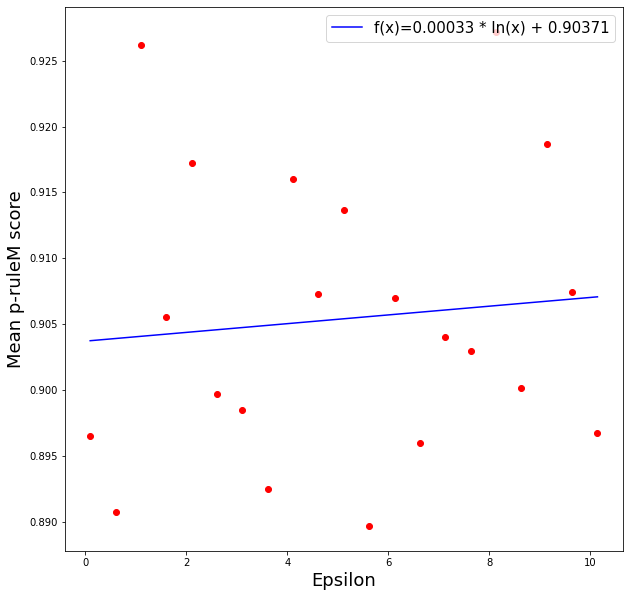

In [58]:
# PLOT OWN P-RULE MEAN

m, b = np.polyfit(epsilons, pRuleOwnMeanArr, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(pRuleOwnMeanArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, pRuleOwnMeanArr, color='r')
plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p-ruleM score", fontsize=18)
#plt.text(18, min(pRuleOwnMeanArr),'statistically significant with P ≤ 0.001', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.legend(loc="upper right", fontsize=15)
plt.savefig('PCAOwnMean.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.8152
Date:                Tue, 08 Jun 2021   Prob (F-statistic):              0.378
Time:                        18:09:00   Log-Likelihood:                 30.697
No. Observations:                  21   AIC:                            -57.39
Df Residuals:                      19   BIC:                            -55.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6478      0.025     25.697      0.0

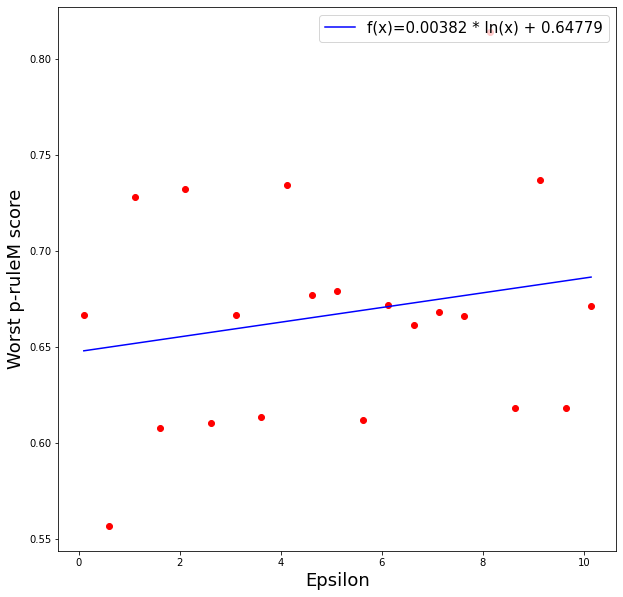

In [63]:
# PLOT OWN P-RULE MIN

m, b = np.polyfit(epsilons, pRuleOwnMinArr, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(pRuleOwnMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, pRuleOwnMinArr, color='r')
plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Worst p-ruleM score", fontsize=18)
#plt.text(18, min(pRuleOwnMinArr),'statistically significant with P ≤ 0.001', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.legend(loc="upper right", fontsize=15)
plt.savefig('PCAOwnMin.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.6831
Date:                Tue, 08 Jun 2021   Prob (F-statistic):              0.419
Time:                        18:08:53   Log-Likelihood:                 77.177
No. Observations:                  21   AIC:                            -150.4
Df Residuals:                      19   BIC:                            -148.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4786      0.003    173.653      0.0

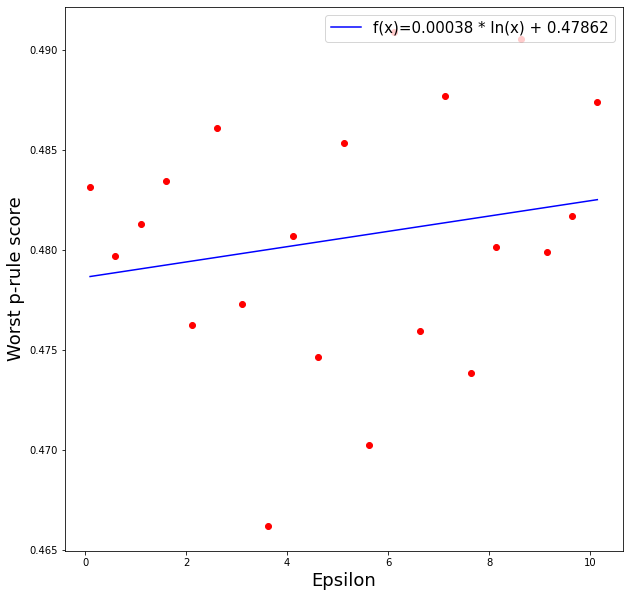

In [62]:
# PLOT OFFICIAL P-RULE MIN
m, b = np.polyfit(epsilons, pRuleMinArr, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(pRuleMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, pRuleMinArr, color='r')
plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Worst p-rule score", fontsize=18)

#plt.text(18, min(pRuleMinArr),'statistically significant with P ≤ 0.001', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})

plt.legend(loc="upper right", fontsize=15)
plt.savefig('PCAOfficialMin.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.156
Date:                Tue, 08 Jun 2021   Prob (F-statistic):              0.296
Time:                        18:08:47   Log-Likelihood:                 67.523
No. Observations:                  21   AIC:                            -131.0
Df Residuals:                      19   BIC:                            -129.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6004      0.004    137.551      0.0

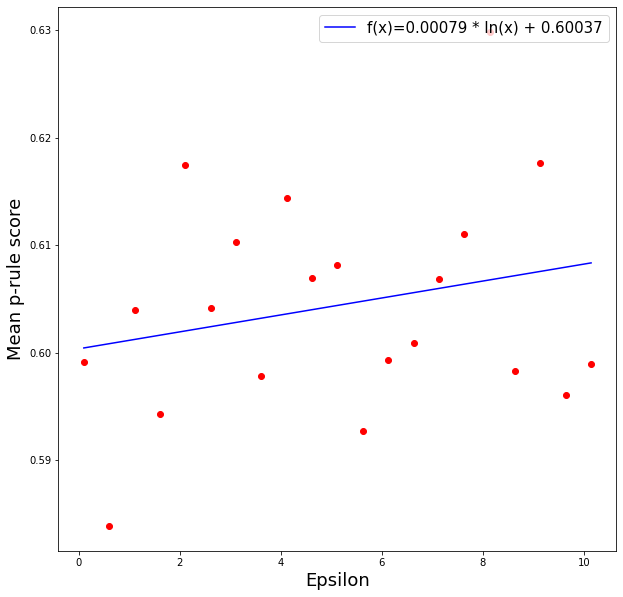

In [61]:
# PLOT OFFICIAL P-RULE Mean
m, b = np.polyfit(epsilons, pRuleMeanArr, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(pRuleMeanArr, X2)
est2 = est.fit()
print(est2.summary())
plt.figure(figsize=(10,10))
plt.scatter(epsilons, pRuleMeanArr, color='r')
plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.text(18, min(pRuleMeanArr),'statistically significant with P ≤ 0.001', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p-rule score", fontsize=18)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('PCAfficialMean.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.5067
Date:                Tue, 08 Jun 2021   Prob (F-statistic):              0.485
Time:                        18:09:20   Log-Likelihood:                 126.54
No. Observations:                  21   AIC:                            -249.1
Df Residuals:                      19   BIC:                            -247.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.000     12.152      0.0

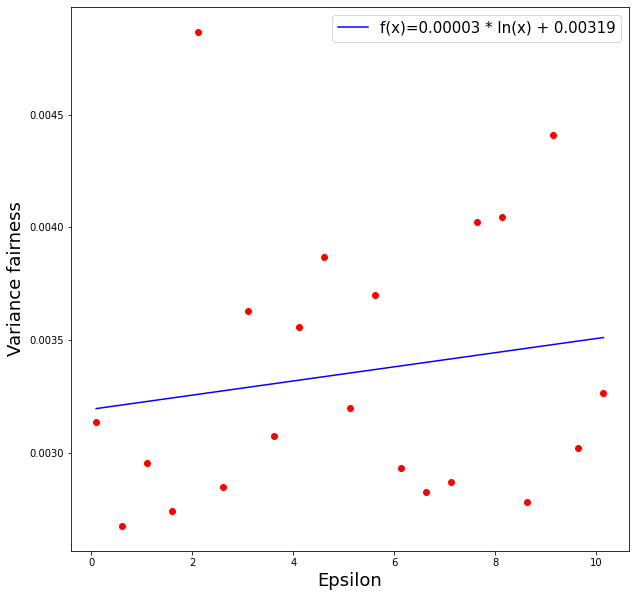

In [64]:
m, b = np.polyfit(epsilons, varF1, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(varF1, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, varF1, color='r')
plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
#plt.text(18, 0.00125,'statistically significant with P ≤ 0.001', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.ylabel("Variance fairness", fontsize=18)
plt.legend(loc="upper right", fontsize=15)
plt.savefig('PCAvarf1.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.047
Method:                 Least Squares   F-statistic:                   0.09432
Date:                Tue, 08 Jun 2021   Prob (F-statistic):              0.762
Time:                        18:09:36   Log-Likelihood:                 60.876
No. Observations:                  21   AIC:                            -117.8
Df Residuals:                      19   BIC:                            -115.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1800      0.006     30.056      0.0

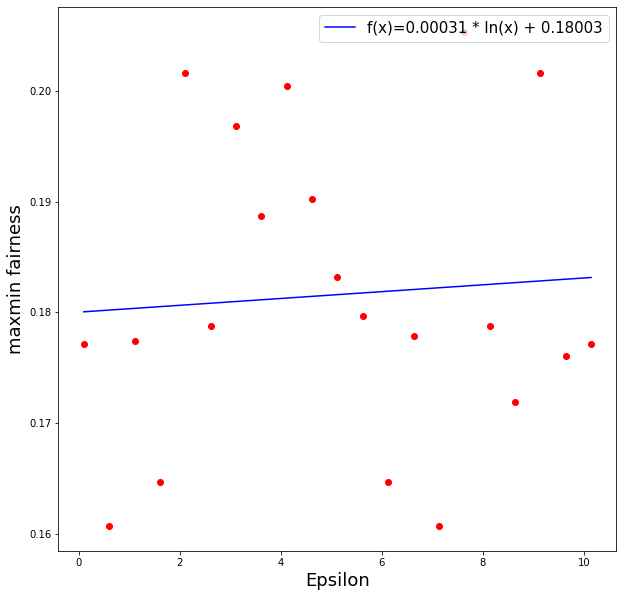

In [65]:
m, b = np.polyfit(epsilons, minMaxF1, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(minMaxF1, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, minMaxF1, color='r')
plt.plot(epsilons, m*epsilons + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("maxmin fairness", fontsize=18)
#plt.text(18, min(minMaxF1),'statistically significant with P ≤ 0.001', fontsize=15,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.legend(loc="upper right", fontsize=15)
plt.savefig('15minmaxf1400models0to40eps.png', bbox_inches='tight')

plt.show()

In [66]:
with open('DPPCA.npy', 'wb') as f:
    np.save(f, epsilons)
    np.save(f, varF1)
    np.save(f, minMaxF1)
    np.save(f, pRuleOwnMeanArr)
    np.save(f, pRuleOwnMinArr)
    np.save(f, pRuleMeanArr)
    np.save(f, pRuleMinArr)
    np.save(f, accuracy)

In [ ]:
with open('DPPCA.npy', 'rb') as f:
    epsilons = np.load(f)
    varF1 = np.load(f)
    minMaxF1 = np.load(f)
    pRuleOwnMeanArr = np.load(f)
    pRuleOwnMinArr = np.load(f)
    pRuleMeanArr = np.load(f)
    pRuleMinArr = np.load(f)
    accuracy = np.load(f)